In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dropout # Import layers directly
from tensorflow.keras.models import Model, Sequential # Import Sequential directly
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt

from google.colab import drive

Experiment: Displays the image resolution and color depth. Also, it is the model tested on rotated images

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to your folder (replace with your actual folder path)
folder_path = '/content/drive/My Drive/split_dataset'

# List files in the folder
os.listdir(folder_path)

['images', 'split_dataset', 'labels', '__MACOSX']

In [ ]:
num_classes = 2
def load_image_and_label(image_path, label_path, image_size=(224, 224), rotate=False):
    image_path = image_path.numpy().decode('utf-8')
    label_path = label_path.numpy().decode('utf-8')

    img = cv2.imread(image_path)
    image_size_int = (int(image_size[0]), int(image_size[1]))
    img = cv2.resize(img, image_size_int)

    # Rotate only if specified
    if rotate:
        angle = np.random.uniform(-30, 30)
        M = cv2.getRotationMatrix2D((image_size[0]//2, image_size[1]//2), angle, 1)
        img = cv2.warpAffine(img, M, image_size_int)

    # Normalize image
    img = img.astype(np.float32) / 255.0

    # Load label and create one-hot vector
    with open(label_path, 'r') as file:
        line = file.readline().strip()
        class_id = int(line.split()[0]) if line else 0

    label_vector = np.zeros(num_classes, dtype=np.float32)
    label_vector[class_id] = 1.0

    # Get resolution and color depth
    resolution = img.shape[:2]  # (height, width)
    color_depth = img.shape[2] if len(img.shape) == 3 else 1
    print(f"Image: {os.path.basename(image_path)} | Resolution: {resolution} | Color Depth: {color_depth}")

    return img, label_vector

In [ ]:
def tf_load_image_and_label(image_path, label_path, image_size=(224, 224), rotate=False):
    img, label = tf.py_function(
        func=lambda img_p, lbl_p: load_image_and_label(img_p, lbl_p, image_size, rotate),
        inp=[image_path, label_path],
        Tout=(tf.float32, tf.float32)
    )
    # Explicitly set the shape of the image tensor
    img.set_shape([image_size[0], image_size[1], 3])
    # Explicitly set the shape of the label tensor
    label.set_shape([num_classes])
    return img, label

In [ ]:
def create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train', show_warnings=True):
    sub_image_dir = os.path.join(image_dir, dataset_type)
    sub_label_dir = os.path.join(label_dir, dataset_type)

    image_paths = [f for f in os.listdir(sub_image_dir) if f.endswith(('.jpg', '.png'))]

    image_file_paths = []
    label_file_paths = []

    for image_name in image_paths:
        base_name = os.path.splitext(image_name)[0]
        label_name = base_name + '.txt'
        label_path = os.path.join(sub_label_dir, label_name)

        if os.path.exists(label_path):
            image_file_paths.append(os.path.join(sub_image_dir, image_name))
            label_file_paths.append(label_path)
        else:
            if show_warnings:
                print(f"Warning: Missing label file for image: {image_name}")

    if not image_file_paths:
        if show_warnings:
            print(f"Warning: No valid image-label pairs found in {sub_image_dir}")
        return None

    rotate = dataset_type == 'test'

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    dataset = dataset.map(
        lambda img_path, lbl_path: tf_load_image_and_label(img_path, lbl_path, image_size, rotate),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if dataset_type == 'train':
        dataset = dataset.shuffle(buffer_size=len(image_file_paths))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# Paths to data
image_dir = '/content/drive/My Drive/split_dataset/images'
label_dir = '/content/drive/My Drive/split_dataset/labels'

# Load datasets
train_dataset = create_dataset(image_dir, label_dir, dataset_type='train')
val_dataset = create_dataset(image_dir, label_dir, dataset_type='val')
test_dataset = create_dataset(image_dir, label_dir, dataset_type='test')

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
if train_dataset is not None and tf.data.experimental.cardinality(train_dataset).numpy() > 0:
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Streaming output truncated to the last 5000 lines.
Image: image_101.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_527.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1228.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1437.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_59.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_2329.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1031.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_387.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_60.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_534.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_218.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1249.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1408.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_2336.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_897.jpg | Resolution: (224, 224) | Color Depth: 3

In [ ]:
# Track training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")

Final Training Loss: 0.06182066351175308
Final Training Accuracy: 0.9789631962776184
Final Validation Loss: 0.0511489175260067
Final Validation Accuracy: 0.9914529919624329


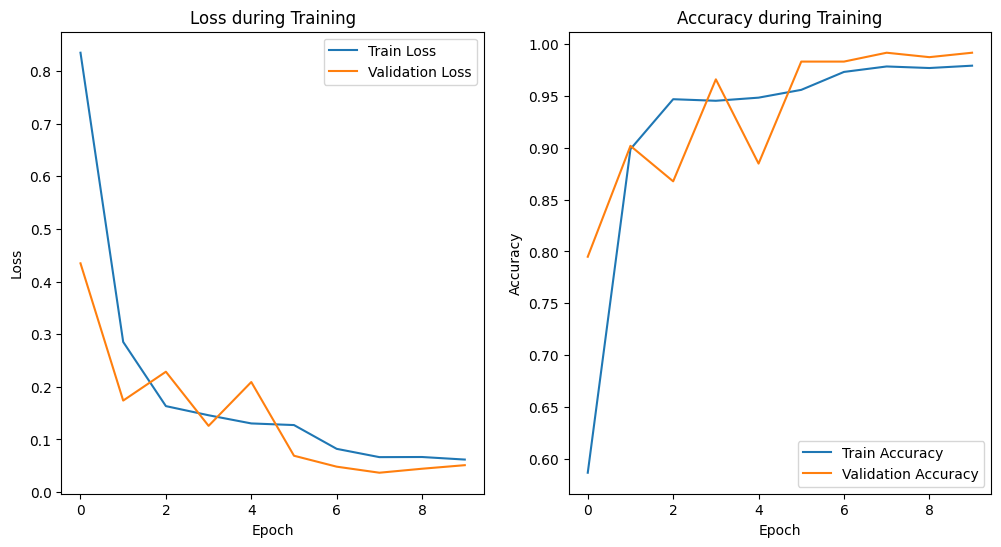

In [ ]:
 # Plot history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Evaluate model on rotated test dataset
if test_dataset is not None:
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

Image: image_18.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_915.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_353.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_896.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1021.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_703.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1551.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_376.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_404.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_361.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1644.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_880.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1411.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_293.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_1445.jpg | Resolution: (224, 224) | Color Depth: 3
Image: image_982.jpg | Resolution: (224, 224) | Col